<a href="https://colab.research.google.com/github/jmcaussade/analitica-textual-con-machine-learning-tarea3/blob/main/Tarea3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laboratorio 3 - Laboratorio de Clasificación utilizando Transformers




## Paso 1: Montar Google Drive
Comenzamos montando Google Drive para acceder al conjunto de datos y guardar cualquier salida.


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive



## Paso 2: Importar las Bibliotecas Necesarias



In [ ]:
import io
import os
import copy
import torch
import json
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
from sklearn.utils.class_weight import compute_class_weight
import warnings

tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings("ignore", category=UserWarning)




## Paso 3: Configuración del Modelo


In [ ]:
model_path = 'dccuchile/bert-base-spanish-wwm-cased'
model_alias = 'BERT'


## Paso 4: Definir Hiperparámetros



In [ ]:
max_length = 512
epochs = 3
batch_size = 8
n_labels = 3
warmup_epochs = 0.2 * epochs
learning_rate = 1e-5


## Paso 5: Cargar el Tokenizador y el Modelo
Cargamos el tokenizador y el modelo utilizando la biblioteca `transformers`. El tokenizador convertirá el texto en tokens que el modelo puede procesar.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_path)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=n_labels)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path,
                                                           config=model_config)

model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


## Paso 6: Cargar y Preprocesar los Datos
Cargamos el conjunto de datos desde un archivo Excel. El conjunto de datos contiene reseñas de restaurantes con una calificación correspondiente. Luego, simplificamos las calificaciones en tres categorías: `Negativo`, `Neutral` y `Positivo`.


In [ ]:
#df = pd.read_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea2ML/df_procesadoOficial.pkl')
df = pd.read_pickle('/content/drive/My Drive/Tarea2ML/df_procesadoOficial.pkl')
df

,id,rank,abstract,review,processed_review,filtered_words,token_count,joined_text
0,1,2,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,"[bien, comente, propietarios, hora, abandonar,...","[hora, momento, vez, granada, situacion, centr...",76,hora momento vez granada situacion centro gran...
1,2,2,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...","[dias, familia, reservando, habitaciones, desa...","[dias, familia, incluido, incluso, parking, es...",84,dias familia incluido incluso parking estancia...
2,3,1,Decepción,Habíamos escogido este hotel por las buenas op...,"[escogido, hotel, buenas, opiniones, verdad, h...","[buenas, verdad, centro, hacia, ruido, poder, ...",53,buenas verdad centro hacia ruido poder suelo p...
3,4,2,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,"[vuelto, segunda, vez, estupendo, hotel, grana...","[vez, estupendo, granada, relacion, calidad, p...",47,vez estupendo granada relacion calidad precio ...
4,5,2,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...","[dias, granada, trabajo, autonomo, busco, ante...","[dias, granada, elegir, pues, situacion, cerca...",91,dias granada elegir pues situacion cerca grana...
...,...,...,...,...,...,...,...,...
1811,1812,2,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,"[empezado, ano, estancia, tres, noches, hotel,...","[estancia, tres, noches, lugar, tranquilo, tra...",116,estancia tres noches lugar tranquilo trato com...
1812,1813,2,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,"[atravesar, umbral, puerta, conduce, zaguan, h...","[puerta, olor, natural, patio, patio, calidad,...",242,puerta olor natural patio patio calidad vista ...
1813,1814,2,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,"[hotel, sensaciones, experiencias, positivas, ...","[ubicado, antigua, calle, ahora, junto, zona, ...",109,ubicado antigua calle ahora junto zona gran ha...
1814,1815,2,Extraordinario,Hemos pasado un par de noches en este exquisit...,"[pasado, par, noches, exquisito, hotel, regent...","[pasado, par, noches, trato, primera, planta, ...",31,pasado par noches trato primera planta cama gu...


In [ ]:
df = df[['abstract', 'review', 'rank']]
df

,abstract,review,rank
0,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,2
1,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...",2
2,Decepción,Habíamos escogido este hotel por las buenas op...,1
3,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,2
4,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...",2
...,...,...,...
1811,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,2
1812,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,2
1813,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,2
1814,Extraordinario,Hemos pasado un par de noches en este exquisit...,2



## Paso 7: Preparar el Conjunto de Datos
Dividimos los datos en conjuntos de entrenamiento y prueba. También creamos un `Dataset` personalizado de PyTorch para manejar las entradas tokenizadas.


rank
2    1020
0     511
1     285
Name: count, dtype: int64


<Axes: xlabel='rank'>

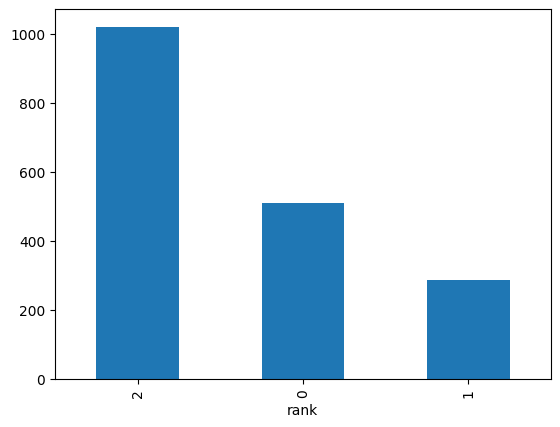

In [ ]:
print(df['rank'].value_counts())
df['rank'].value_counts().plot(kind='bar')

In [ ]:
tok_example = tokenizer(df['review'].iloc[0], return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
tok_example

{'input_ids': tensor([[    4,  2144,  1311,  2027,  5609, 30958,  1013,  1065, 12220,  1013,
          1030,  2709,  1008,  9981,  1040,  5225,  1017,  1084, 22340, 30958,
          1049,  1989,  1036, 17274,  1108,  1042,  1861,  1480,  1040,  9762,
         21296, 30933,  1008, 13410,  1009,  1508,  2504,  2440,  1072,  3040,
          1008, 13410,  1084,  1058,  1030,  1627,  1017,  1355,  1110,  3070,
         17182,  1538,  6719,  1147, 19189,  1093,  1008,  1377,  1008,  3165,
          1051,  6054,  1013,  1030,  1403,  5159,  2883,  1135,  1009,  1264,
          2858,  1036,  1030,  6278,  1008,  3661,  1013,  8909, 24408,  1042,
          1456, 10082,  1013,  1030,  1403,  5159,  2883,  1009,  1278,  1030,
          2785,  1062,  1499,  2604, 18173,  1042,  1365,  1062,  2858,  1036,
          1108,  2785,  4488,  1042, 13248,  1009,  1412,  1080,   981,  9794,
          1072,  3040,  1008, 13410,  1038,  1445, 17274,  1022,  1036,  1040,
          5225,  2351,  1114,  1038,  

In [ ]:
tokenizer.decode(tok_example['input_ids'][0])

'[CLS] Como bien les comenté a los propietarios a la hora de abandonar el hotel, no dudaré un momento en recomendar una y otra vez el Hotel Albero de Granada. Su situación respecto del centro de Granada no es la mejor, pero para nuestros propósitos era perfecto ( escapada de fin de semana con visita a la Alhambra ). Se encuentra en la carretera de paso a Sierra Nevada y muy cercano a la Alhambra. Por la zona se puede encontrar aparcamiento y este se encuentra en una zona segura y tranquila. Los parkings del centro de Granada que nos recomendaron en el hotel fueron lo que nos dijeron ( nada caros ) y pudimos movernos por el centro perfectamente desde allí. Las habitaciones muy limpias y las camas confortables. El desayuno fue espectacular. Ya teníamos buenas referencias de este maravilloso hotel de una estrella ( que para mí que viajo constantemente son más ) pero ha superado con creces nuestras expectativas. Si vuelvo a Granada no dudaré en hospedarme en el mismo hotel. Muchas gracias 

Ahora podemos utilizar dos secuencias de texto individuales pero tokenizarlas juntas agregando el token serarador ([SEP] en el caso de BETO).

In [ ]:
tok_doble_example = tokenizer(df['abstract'].iloc[0], df['review'].iloc[0], return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
tok_doble_example

{'input_ids': tensor([[    4,  1246,  5225, 16901,  1008, 15450,  1127,     5,  2144,  1311,
          2027,  5609, 30958,  1013,  1065, 12220,  1013,  1030,  2709,  1008,
          9981,  1040,  5225,  1017,  1084, 22340, 30958,  1049,  1989,  1036,
         17274,  1108,  1042,  1861,  1480,  1040,  9762, 21296, 30933,  1008,
         13410,  1009,  1508,  2504,  2440,  1072,  3040,  1008, 13410,  1084,
          1058,  1030,  1627,  1017,  1355,  1110,  3070, 17182,  1538,  6719,
          1147, 19189,  1093,  1008,  1377,  1008,  3165,  1051,  6054,  1013,
          1030,  1403,  5159,  2883,  1135,  1009,  1264,  2858,  1036,  1030,
          6278,  1008,  3661,  1013,  8909, 24408,  1042,  1456, 10082,  1013,
          1030,  1403,  5159,  2883,  1009,  1278,  1030,  2785,  1062,  1499,
          2604, 18173,  1042,  1365,  1062,  2858,  1036,  1108,  2785,  4488,
          1042, 13248,  1009,  1412,  1080,   981,  9794,  1072,  3040,  1008,
         13410,  1038,  1445, 17274,  

In [ ]:
tokenizer.decode(tok_doble_example['input_ids'][0])

'[CLS] Un hotel digno de mención! [SEP] Como bien les comenté a los propietarios a la hora de abandonar el hotel, no dudaré un momento en recomendar una y otra vez el Hotel Albero de Granada. Su situación respecto del centro de Granada no es la mejor, pero para nuestros propósitos era perfecto ( escapada de fin de semana con visita a la Alhambra ). Se encuentra en la carretera de paso a Sierra Nevada y muy cercano a la Alhambra. Por la zona se puede encontrar aparcamiento y este se encuentra en una zona segura y tranquila. Los parkings del centro de Granada que nos recomendaron en el hotel fueron lo que nos dijeron ( nada caros ) y pudimos movernos por el centro perfectamente desde allí. Las habitaciones muy limpias y las camas confortables. El desayuno fue espectacular. Ya teníamos buenas referencias de este maravilloso hotel de una estrella ( que para mí que viajo constantemente son más ) pero ha superado con creces nuestras expectativas. Si vuelvo a Granada no dudaré en hospedarme e

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
class DatasetFromDataFrame(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = int(self.data.iloc[index]['rank'])
        text_1 = str(self.data.iloc[index]['abstract'])
        text_2 = str(self.data.iloc[index]['review']) ###
        return label, text_1, text_2

In [ ]:
train_dataset = DatasetFromDataFrame(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset =  DatasetFromDataFrame(val_df)
test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



## Paso 8: Entrenamiento del Modelo



In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate)

### 8.1 Solo Review

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       102
           1       0.45      0.09      0.15        55
           2       0.81      1.00      0.90       207

    accuracy                           0.83       364
   macro avg       0.73      0.66      0.65       364
weighted avg       0.79      0.83      0.79       364

*** Best Epoch: 1, Best Accuracy: 0.8324175824175825 ***


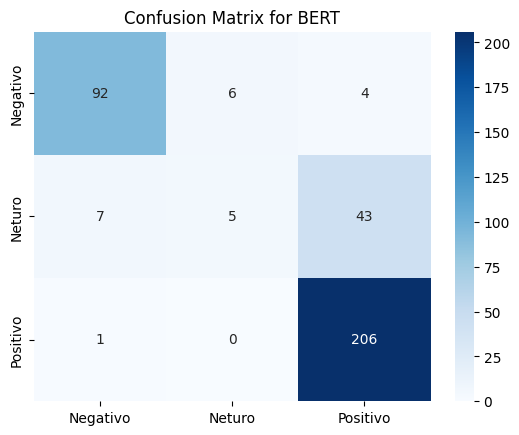

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       102
           1       0.56      0.36      0.44        55
           2       0.88      0.96      0.92       207

    accuracy                           0.85       364
   macro avg       0.77      0.74      0.75       364
weighted avg       0.83      0.85      0.84       364

*** Best Epoch: 2, Best Accuracy: 0.8516483516483516 ***


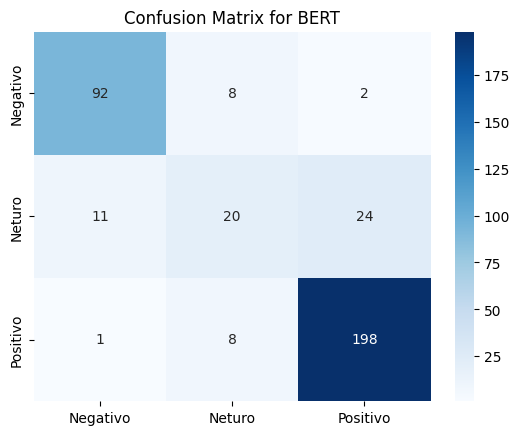

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       102
           1       0.48      0.55      0.51        55
           2       0.90      0.93      0.91       207

    accuracy                           0.84       364
   macro avg       0.78      0.77      0.77       364
weighted avg       0.85      0.84      0.84       364



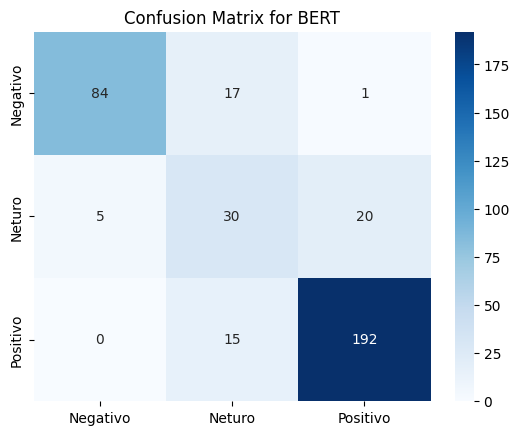

,class,precision,recall,f1-score,model,lema state
0,0,0.884615,0.901961,0.893204,BETO solo Comentario,N.A.
1,1,0.555556,0.363636,0.439560,BETO solo Comentario,N.A.
2,2,0.883929,0.956522,0.918794,BETO solo Comentario,N.A.
3,accuracy,0.851648,0.851648,0.851648,BETO solo Comentario,N.A.
4,macro avg,0.774700,0.740706,0.750519,BETO solo Comentario,N.A.
5,weighted avg,0.834504,0.851648,0.839211,BETO solo Comentario,N.A.


In [ ]:
best_epoch = 0
best_accuracy = 0

for epoch in tqdm(range(epochs)):

    # TRAINING
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    t_bar = tqdm(train_dataloader)
    model.train()

    for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        model.zero_grad()
        optimizer.zero_grad()

        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        t_bar.set_description(f'Training... EPOCH {epoch+1} Step Loss {total_loss/(step_counter+1):4f}, Epoch Accuracy {epoch_report["accuracy"]:4f}')
        t_bar.refresh()


    # EVALUATION
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    v_bar = tqdm(test_dataloader)
    model.eval()

    for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
        labels = labels.to(device)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs = tokenizer(text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        outputs = model(**inputs)

        loss = outputs.loss

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        v_bar.set_description(f'Training... EPOCH {epoch+1} Avg Loss {total_loss/(step_counter+1):4f}, Avg Accuracy {epoch_report["accuracy"]:4f}')
        v_bar.refresh()

    evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
    print(classification_report(epoch_true_labels, epoch_predicted_labels))
    epoch_accuracy = evaluations_report['accuracy']

    if epoch_accuracy > best_accuracy:
        best_epoch = epoch + 1
        best_accuracy = epoch_accuracy
        best_report = evaluations_report
        print(f'*** Best Epoch: {best_epoch}, Best Accuracy: {best_accuracy} ***')

    conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)

    fig, ax = plt.subplots()
    plt.title(f'Confusion Matrix for {model_alias}')
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2},
                yticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2})
    plt.show()


beto_results_df_review = pd.DataFrame(best_report).T
beto_results_df_review['model'] = 'BETO solo Comentario'
beto_results_df_review['lema state'] = 'N.A.'
beto_results_df_review = beto_results_df_review.drop(columns = ['support'])
beto_results_df_review = beto_results_df_review.reset_index()
beto_results_df_review.rename(columns={'index': 'class'}, inplace=True)

beto_results_df_review

### 8.2 Entrenamiento Titulo y Comentario

In [ ]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=n_labels)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path,
                                                           config=model_config)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.83      0.88       102
           1       0.54      0.53      0.53        55
           2       0.91      0.96      0.93       207

    accuracy                           0.86       364
   macro avg       0.79      0.77      0.78       364
weighted avg       0.86      0.86      0.86       364

*** Best Epoch: 1, Best Accuracy: 0.8571428571428571 ***


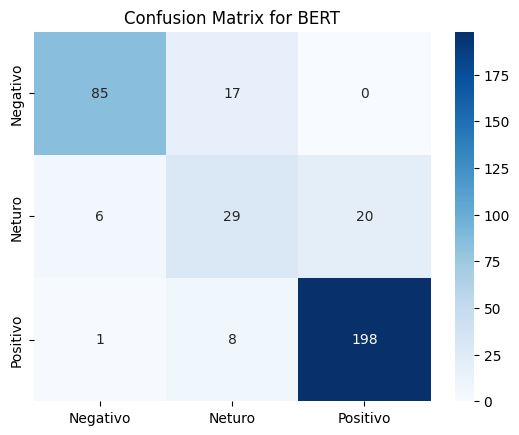

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       102
           1       0.66      0.35      0.45        55
           2       0.88      0.98      0.93       207

    accuracy                           0.87       364
   macro avg       0.81      0.75      0.77       364
weighted avg       0.85      0.87      0.85       364

*** Best Epoch: 2, Best Accuracy: 0.8708791208791209 ***


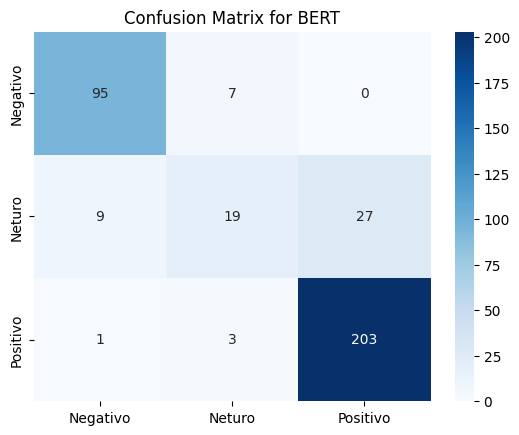

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       102
           1       0.52      0.45      0.49        55
           2       0.90      0.96      0.93       207

    accuracy                           0.85       364
   macro avg       0.78      0.76      0.77       364
weighted avg       0.85      0.85      0.85       364



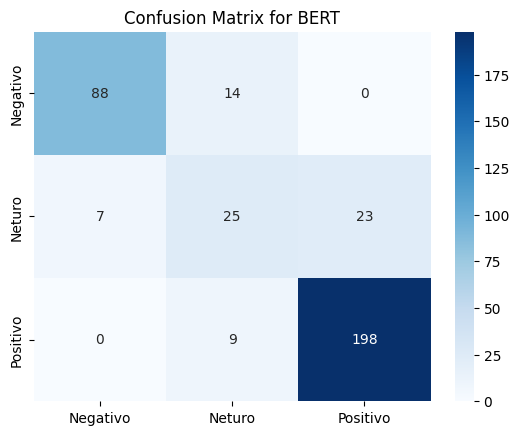

,class,precision,recall,f1-score,model,lema state
0,0,0.904762,0.931373,0.917874,BETO Titulo y Comentario,N.A.
1,1,0.655172,0.345455,0.452381,BETO Titulo y Comentario,N.A.
2,2,0.882609,0.980676,0.929062,BETO Titulo y Comentario,N.A.
3,accuracy,0.870879,0.870879,0.870879,BETO Titulo y Comentario,N.A.
4,macro avg,0.814181,0.752501,0.766439,BETO Titulo y Comentario,N.A.
5,weighted avg,0.854451,0.870879,0.853901,BETO Titulo y Comentario,N.A.


In [ ]:
best_epoch = 0
best_accuracy = 0

for epoch in tqdm(range(epochs)):

    # TRAINING
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    t_bar = tqdm(train_dataloader)
    model.train()

    for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        model.zero_grad()
        optimizer.zero_grad()

        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        t_bar.set_description(f'Training... EPOCH {epoch+1} Step Loss {total_loss/(step_counter+1):4f}, Epoch Accuracy {epoch_report["accuracy"]:4f}')
        t_bar.refresh()


    # EVALUATION
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    v_bar = tqdm(test_dataloader)
    model.eval()

    for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        outputs = model(**inputs)

        loss = outputs.loss

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        v_bar.set_description(f'Training... EPOCH {epoch+1} Avg Loss {total_loss/(step_counter+1):4f}, Avg Accuracy {epoch_report["accuracy"]:4f}')
        v_bar.refresh()

    evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
    print(classification_report(epoch_true_labels, epoch_predicted_labels))
    epoch_accuracy = evaluations_report['accuracy']

    if epoch_accuracy > best_accuracy:
        best_epoch = epoch + 1
        best_accuracy = epoch_accuracy
        best_report = evaluations_report
        print(f'*** Best Epoch: {best_epoch}, Best Accuracy: {best_accuracy} ***')

    conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)

    fig, ax = plt.subplots()
    plt.title(f'Confusion Matrix for {model_alias}')
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2},
                yticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2})
    plt.show()


beto_results_df_abs_plus_review = pd.DataFrame(best_report).T
beto_results_df_abs_plus_review['model'] = 'BETO Titulo y Comentario'
beto_results_df_abs_plus_review['lema state'] = 'N.A.'
beto_results_df_abs_plus_review = beto_results_df_abs_plus_review.drop(columns = ['support'])
beto_results_df_abs_plus_review = beto_results_df_abs_plus_review.reset_index()
beto_results_df_abs_plus_review.rename(columns={'index': 'class'}, inplace=True)

beto_results_df_abs_plus_review

### 8.3 Entrenamiento solo titulo

In [ ]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=n_labels)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_path,
                                                           config=model_config)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       102
           1       0.41      0.25      0.31        55
           2       0.87      0.88      0.87       207

    accuracy                           0.78       364
   macro avg       0.67      0.67      0.66       364
weighted avg       0.76      0.78      0.77       364

*** Best Epoch: 1, Best Accuracy: 0.7802197802197802 ***


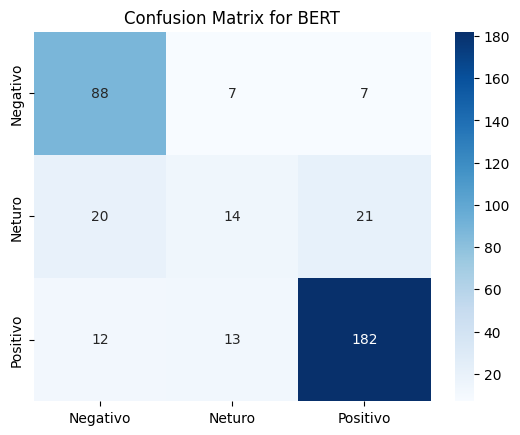

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.69      0.91      0.79       102
           1       0.43      0.27      0.33        55
           2       0.88      0.83      0.86       207

    accuracy                           0.77       364
   macro avg       0.67      0.67      0.66       364
weighted avg       0.76      0.77      0.76       364



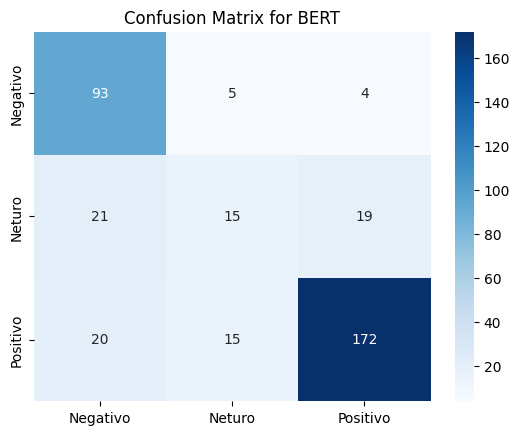

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       102
           1       0.38      0.36      0.37        55
           2       0.88      0.83      0.85       207

    accuracy                           0.77       364
   macro avg       0.67      0.69      0.68       364
weighted avg       0.77      0.77      0.77       364



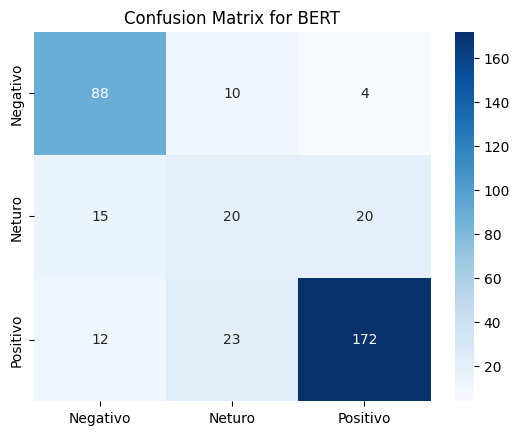

,class,precision,recall,f1-score,model,lema state
0,0,0.733333,0.862745,0.792793,BETO solo Titulo,N.A.
1,1,0.411765,0.254545,0.314607,BETO solo Titulo,N.A.
2,2,0.866667,0.879227,0.872902,BETO solo Titulo,N.A.
3,accuracy,0.780220,0.780220,0.780220,BETO solo Titulo,N.A.
4,macro avg,0.670588,0.665506,0.660100,BETO solo Titulo,N.A.
5,weighted avg,0.760569,0.780220,0.766096,BETO solo Titulo,N.A.


In [ ]:
best_epoch = 0
best_accuracy = 0

for epoch in tqdm(range(epochs)):

    # TRAINING
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    t_bar = tqdm(train_dataloader)
    model.train()

    for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
        labels = labels.to(device)
        inputs = tokenizer(text_1, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        model.zero_grad()
        optimizer.zero_grad()

        outputs = model(**inputs)

        loss = outputs.loss
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        t_bar.set_description(f'Training... EPOCH {epoch+1} Step Loss {total_loss/(step_counter+1):4f}, Epoch Accuracy {epoch_report["accuracy"]:4f}')
        t_bar.refresh()


    # EVALUATION
    epoch_true_labels = []
    epoch_predicted_labels = []
    total_loss = 0

    v_bar = tqdm(test_dataloader)
    model.eval()

    for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
        labels = labels.to(device)
        # inputs = tokenizer(text_1, text_2, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs = tokenizer(text_1, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs['labels'] = labels
        inputs = {k:v.type(torch.long).to(device) for k,v in inputs.items()}

        outputs = model(**inputs)

        loss = outputs.loss

        total_loss += loss.item()

        predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

        epoch_true_labels.extend(labels.cpu().tolist())
        epoch_predicted_labels.extend(predicted_labels)


        epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        v_bar.set_description(f'Training... EPOCH {epoch+1} Avg Loss {total_loss/(step_counter+1):4f}, Avg Accuracy {epoch_report["accuracy"]:4f}')
        v_bar.refresh()

    evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
    print(classification_report(epoch_true_labels, epoch_predicted_labels))
    epoch_accuracy = evaluations_report['accuracy']

    if epoch_accuracy > best_accuracy:
        best_epoch = epoch + 1
        best_accuracy = epoch_accuracy
        best_report = evaluations_report
        print(f'*** Best Epoch: {best_epoch}, Best Accuracy: {best_accuracy} ***')

    conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)

    fig, ax = plt.subplots()
    plt.title(f'Confusion Matrix for {model_alias}')
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2},
                yticklabels={'Negativo': 0,
                            'Neturo': 1,
                            'Positivo': 2})
    plt.show()


beto_results_df_abs = pd.DataFrame(best_report).T
beto_results_df_abs['model'] = 'BETO solo Titulo'
beto_results_df_abs['lema state'] = 'N.A.'
beto_results_df_abs = beto_results_df_abs.drop(columns = ['support'])
beto_results_df_abs = beto_results_df_abs.reset_index()
beto_results_df_abs.rename(columns={'index': 'class'}, inplace=True)

beto_results_df_abs

## Paso 9: Manejo resultados

### 9.1 Solo review

In [ ]:
#df_solo_review = pd.read_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea2ML/BaseLab3/df_procesadoExportadoTarea2_SOLOREVIEW.pkl')
df_solo_review = pd.read_pickle('/content/drive/My Drive/Tarea2ML/BaseLab3/df_procesadoExportadoTarea2_SOLOREVIEW.pkl')
df_solo_review

,class,precision,recall,f1-score,model,lema state
0,0,0.363636,0.431373,0.394619,Naive Bayes,Lemma
1,1,0.157895,0.054545,0.081081,Naive Bayes,Lemma
2,2,0.656250,0.710145,0.682135,Naive Bayes,Lemma
3,accuracy,0.532967,0.532967,0.532967,Naive Bayes,Lemma
4,macro avg,0.392594,0.398688,0.385945,Naive Bayes,Lemma
...,...,...,...,...,...,...
67,1,0.153846,0.072727,0.098765,Neural Network,Not Lemma
68,2,0.582090,0.565217,0.573529,Neural Network,Not Lemma
69,accuracy,0.450549,0.450549,0.450549,Neural Network,Not Lemma
70,macro avg,0.349935,0.353171,0.344042,Neural Network,Not Lemma


In [ ]:
results_df_solo_review = pd.concat([df_solo_review, beto_results_df_review])
results_df_solo_review.reset_index(inplace=True)
results_d_solo_review = results_df_solo_review.drop(columns = ['index'])
results_df_solo_review

,index,class,precision,recall,f1-score,model,lema state
0,0,0,0.363636,0.431373,0.394619,Naive Bayes,Lemma
1,1,1,0.157895,0.054545,0.081081,Naive Bayes,Lemma
2,2,2,0.656250,0.710145,0.682135,Naive Bayes,Lemma
3,3,accuracy,0.532967,0.532967,0.532967,Naive Bayes,Lemma
4,4,macro avg,0.392594,0.398688,0.385945,Naive Bayes,Lemma
...,...,...,...,...,...,...,...
73,1,1,0.555556,0.363636,0.439560,BETO solo Comentario,N.A.
74,2,2,0.883929,0.956522,0.918794,BETO solo Comentario,N.A.
75,3,accuracy,0.851648,0.851648,0.851648,BETO solo Comentario,N.A.
76,4,macro avg,0.774700,0.740706,0.750519,BETO solo Comentario,N.A.


### 9.2 Solo título y Título + Review

In [ ]:
#df_abs_and_abs_plus_review = pd.read_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea2ML/BaseLab3/df_procesadoExportadoTarea2_SOLOTITULO_PLUS_CONCATENACION.pkl')
df_abs_and_abs_plus_review = pd.read_pickle('/content/drive/My Drive/Tarea2ML/BaseLab3/df_procesadoExportadoTarea2_SOLOTITULO_PLUS_CONCATENACION.pkl')
df_abs_and_abs_plus_review

,class,precision,recall,f1-score,model,feature_set
0,0,0.750000,0.647059,0.694737,Naive Bayes,abstract
1,1,0.666667,0.072727,0.131148,Naive Bayes,abstract
2,2,0.744444,0.971014,0.842767,Naive Bayes,abstract
3,accuracy,0.744505,0.744505,0.744505,Naive Bayes,abstract
4,macro avg,0.720370,0.563600,0.556217,Naive Bayes,abstract
...,...,...,...,...,...,...
67,1,0.428571,0.381818,0.403846,Neural Network,abstract + comentario_tokenizado_lema
68,2,0.858491,0.879227,0.868735,Neural Network,abstract + comentario_tokenizado_lema
69,accuracy,0.793956,0.793956,0.793956,Neural Network,abstract + comentario_tokenizado_lema
70,macro avg,0.707338,0.701394,0.703869,Neural Network,abstract + comentario_tokenizado_lema


In [ ]:
#Separamos en 2 dataframes

df_abstract = df_abs_and_abs_plus_review[df_abs_and_abs_plus_review['feature_set'] == 'abstract']
df_abstract_comentario = df_abs_and_abs_plus_review[df_abs_and_abs_plus_review['feature_set'] == 'abstract + comentario_tokenizado_lema']


#### 9.1.1 Solo titulo

In [ ]:
results_df_solo_titulo = pd.concat([df_abstract, beto_results_df_abs])
results_df_solo_titulo.reset_index(inplace=True)
results_d_solo_titulo = results_df_solo_titulo.drop(columns = ['index'])
results_df_solo_titulo

,index,class,precision,recall,f1-score,model,feature_set,lema state
0,0,0,0.750000,0.647059,0.694737,Naive Bayes,abstract,NaN
1,1,1,0.666667,0.072727,0.131148,Naive Bayes,abstract,NaN
2,2,2,0.744444,0.971014,0.842767,Naive Bayes,abstract,NaN
3,3,accuracy,0.744505,0.744505,0.744505,Naive Bayes,abstract,NaN
4,4,macro avg,0.720370,0.563600,0.556217,Naive Bayes,abstract,NaN
5,5,weighted avg,0.734249,0.744505,0.693761,Naive Bayes,abstract,NaN
6,6,0,0.717172,0.696078,0.706468,Logistic Regression,abstract,NaN
7,7,1,0.380952,0.145455,0.210526,Logistic Regression,abstract,NaN
8,8,2,0.782787,0.922705,0.847007,Logistic Regression,abstract,NaN
9,9,accuracy,0.741758,0.741758,0.741758,Logistic Regression,abstract,NaN


#### 9.1.2  Titulo + review

In [ ]:
results_df_abstract_comentario = pd.concat([df_abstract_comentario, beto_results_df_abs_plus_review])
results_df_abstract_comentario.reset_index(inplace=True)
results_df_abstract_comentario = results_df_abstract_comentario.drop(columns = ['index'])
results_df_abstract_comentario

,class,precision,recall,f1-score,model,feature_set,lema state
0,0,0.819048,0.843137,0.830918,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
1,1,0.333333,0.018182,0.034483,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
2,2,0.792969,0.980676,0.876890,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
3,accuracy,0.796703,0.796703,0.796703,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
4,macro avg,0.648450,0.613998,0.580763,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
5,weighted avg,0.730826,0.796703,0.736721,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
6,0,0.846154,0.862745,0.854369,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
7,1,0.312500,0.090909,0.140845,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
8,2,0.811475,0.956522,0.878049,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
9,accuracy,0.799451,0.799451,0.799451,Logistic Regression,abstract + comentario_tokenizado_lema,NaN


## Paso 10: Resultados

### 10.1 Solo review

In [ ]:
# Sorting the DataFrame by 'f1-score' in descending order
results_df_solo_comentario = results_df_solo_review.sort_values(by='f1-score', ascending=False)


In [ ]:
# Display the sorted DataFrame
results_df_solo_comentario.loc[results_df_solo_comentario['class'] == 'weighted avg'].sort_values(by=['f1-score'])

,index,class,precision,recall,f1-score,model,lema state
71,71,weighted avg,0.442222,0.450549,0.441911,Neural Network,Not Lemma
65,65,weighted avg,0.463489,0.442308,0.445712,Decision Tree,Not Lemma
59,59,weighted avg,0.443859,0.502747,0.469305,Random Forest,Not Lemma
35,35,weighted avg,0.492379,0.458791,0.470816,Neural Network,Lemma
47,47,weighted avg,0.437851,0.519231,0.474787,Logistic Regression,Not Lemma
53,53,weighted avg,0.445273,0.538462,0.485178,SVM,Not Lemma
29,29,weighted avg,0.508845,0.497253,0.495541,Decision Tree,Lemma
41,41,weighted avg,0.482099,0.532967,0.501066,Naive Bayes,Not Lemma
17,17,weighted avg,0.460714,0.554945,0.502449,SVM,Lemma
11,11,weighted avg,0.465005,0.557692,0.505609,Logistic Regression,Lemma


### 10.2 Titulo + Review

In [ ]:
# Sorting the DataFrame by 'f1-score' in descending order
results_df_abstract_comentario_sorted = results_df_abstract_comentario.sort_values(by='f1-score', ascending=False)


In [ ]:
# Display the sorted DataFrame
results_df_abstract_comentario_sorted.loc[results_df_abstract_comentario_sorted['class'] == 'weighted avg'].sort_values(by=['f1-score'])

,class,precision,recall,f1-score,model,feature_set,lema state
29,weighted avg,0.676506,0.662088,0.668579,Decision Tree,abstract + comentario_tokenizado_lema,NaN
23,weighted avg,0.660733,0.777473,0.713270,Random Forest,abstract + comentario_tokenizado_lema,NaN
5,weighted avg,0.730826,0.796703,0.736721,Naive Bayes,abstract + comentario_tokenizado_lema,NaN
11,weighted avg,0.745798,0.799451,0.760023,Logistic Regression,abstract + comentario_tokenizado_lema,NaN
17,weighted avg,0.786077,0.818681,0.768680,SVM,abstract + comentario_tokenizado_lema,NaN
35,weighted avg,0.786934,0.793956,0.790165,Neural Network,abstract + comentario_tokenizado_lema,NaN
41,weighted avg,0.854451,0.870879,0.853901,BETO Titulo y Comentario,NaN,N.A.


### 10.3 Solo Titulo

In [ ]:
# Sorting the DataFrame by 'f1-score' in descending order
results_df_solo_titulo_sorted = results_df_solo_titulo.sort_values(by='f1-score', ascending=False)

# Display the sorted DataFrame
results_df_solo_titulo_sorted.loc[results_df_solo_titulo_sorted['class'] == 'weighted avg'].sort_values(by=['f1-score'])

,index,class,precision,recall,f1-score,model,feature_set,lema state
5,5,weighted avg,0.734249,0.744505,0.693761,Naive Bayes,abstract,NaN
29,29,weighted avg,0.698806,0.703297,0.699654,Decision Tree,abstract,NaN
11,11,weighted avg,0.703683,0.741758,0.711453,Logistic Regression,abstract,NaN
23,23,weighted avg,0.716293,0.741758,0.720639,Random Forest,abstract,NaN
35,35,weighted avg,0.720749,0.728022,0.723488,Neural Network,abstract,NaN
17,17,weighted avg,0.738162,0.763736,0.728274,SVM,abstract,NaN
41,5,weighted avg,0.760569,0.780220,0.766096,BETO solo Titulo,NaN,N.A.


In [ ]:
# Display the sorted DataFrame
results_df_solo_titulo_sorted.loc[results_df_solo_titulo_sorted['class'] == 'weighted avg'].sort_values(by=['f1-score'])

,index,class,precision,recall,f1-score,model,feature_set,lema state
5,5,weighted avg,0.734249,0.744505,0.693761,Naive Bayes,abstract,NaN
29,29,weighted avg,0.698806,0.703297,0.699654,Decision Tree,abstract,NaN
11,11,weighted avg,0.703683,0.741758,0.711453,Logistic Regression,abstract,NaN
23,23,weighted avg,0.716293,0.741758,0.720639,Random Forest,abstract,NaN
35,35,weighted avg,0.720749,0.728022,0.723488,Neural Network,abstract,NaN
17,17,weighted avg,0.738162,0.763736,0.728274,SVM,abstract,NaN
41,5,weighted avg,0.760569,0.780220,0.766096,BETO solo Titulo,NaN,N.A.
